In [24]:
import pandas as pd
import numpy as np
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# BTC

In [25]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

### ADX calculation
Below 20: Indicates a weak trend or a ranging market. The asset is likely moving sideways, and trading strategies that depend on trend-following may be less effective. <br>
20 to 25: Indicates a potential emerging trend. Traders may begin to look for signals to enter positions. <br>
25 to 40: Indicates a strengthening trend. This is often where trend-following strategies can be more effective. Depending on the asset, this could be considered a moderately strong trend. <br>
40 to 60: Indicates a strong trend. Here, the asset is trending strongly in one direction, making it more suitable for trend-following strategies. <br>
Above 60: Indicates an extremely strong trend, which might also signal an overbought or oversold condition, suggesting potential reversals. <br>

In [26]:
# Calculate lagged prices
btc['PrevHigh'] = btc['High'].shift(1)
btc['PrevLow'] = btc['Low'].shift(1)
btc['PrevClose'] = btc['Close'].shift(1)

# Calculate true range component
btc['TR1'] = btc['High'] - btc['Low']
btc['TR2'] = abs(btc['High'] - btc['PrevClose'])
btc['TR3'] = abs(btc['Low'] - btc['PrevClose'])

# Calculate true range as the max of the three TRs
btc['TR'] = btc[['TR1', 'TR2', 'TR3']].max(axis=1)
btc.at[btc.index[0], 'TR'] = np.nan

In [27]:
# Initialize +DM and -DM columns
btc['+DM'] = 0.0
btc['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(btc)):
    high_diff = btc['High'].iloc[i] - btc['PrevHigh'].iloc[i]
    low_diff = btc['PrevLow'].iloc[i] - btc['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        btc.at[btc.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        btc.at[btc.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
btc['TR_smooth'] = btc['TR'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

btc['+DM_smooth'] = btc['+DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '+DM_smooth'] = np.nan
btc['-DM_smooth'] = btc['-DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
btc['+DI'] = (btc['+DM_smooth'] / btc['TR_smooth']) * 100
btc['-DI'] = (btc['-DM_smooth'] / btc['TR_smooth']) * 100

# Calculate DX and ADX
btc['DX'] = (abs(btc['+DI'] - btc['-DI']) / (btc['+DI'] + btc['-DI'])) * 100
btc['ADX'] = btc['DX'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [28]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Separate gains and losses
btc['Gain'] = btc['PriceChange'].where(btc['PriceChange'] > 0, 0)
btc['Loss'] = -btc['PriceChange'].where(btc['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

btc.loc[btc.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator
Varies from value of 0 to 100, the bounds of 80 and 20 are frequently taken as overbought and oversold levels

In [29]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

### MACD

In [30]:
btc['EMA_6'] = btc['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

### Breaking of 2 consecutive high

In [31]:
btc['PrevHigh2'] = btc['High'].shift(2)
btc['BreakHigh2'] = (btc['High'] > btc['PrevHigh']) & (btc['PrevHigh'] > btc['PrevHigh2'])

In [32]:
btc['TROpen'] = btc['Open'].diff()
btc['TRHigh'] = btc['High'].diff()
btc['TRLow'] = btc['Low'].diff()
btc['TRClose'] = btc['Close'].diff()
btc['TRShort_SMA'] = btc['SMAVG (5)  on Close'].diff()
btc['TRLong_SMA'] = btc['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
btc['Short_EMA'] = btc['Close'].ewm(span=5, adjust=False).mean()
btc['Long_EMA'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['TRShort_EMA'] = btc['Short_EMA'].diff()
btc['TRLong_EMA'] = btc['Long_EMA'].diff()

btc['DayOfWeek'] = btc['Date'].dt.dayofweek

### Final BTC data (stationary)

In [33]:
btc = btc.drop(columns=['Open', 'High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
btc.drop(index=btc.index[:20], inplace=True)
btc

,Date,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek
20,2024-01-01 10:00:00,42535.88,34.638980,46.213708,68.685093,71.478756,11.198485,False,115.85,-120.74,37.03,-64.03,51.21,-7.52,17.240130,12.363108,0
21,2024-01-01 10:30:00,42573.60,35.421038,53.400626,74.354119,73.782507,20.190863,False,-64.03,-25.50,-21.64,37.72,32.20,6.33,24.066754,16.973452,0
22,2024-01-01 11:00:00,42430.38,31.442584,44.126566,52.829253,65.289488,5.852152,False,37.72,-15.98,-72.83,-143.22,-6.96,-12.13,-31.695498,-12.152630,0
23,2024-01-01 11:30:00,42330.18,30.377071,53.763073,37.769963,54.984445,-16.284526,False,-143.22,-129.37,-171.35,-100.20,-30.78,6.38,-54.530332,-28.161243,0
24,2024-01-01 12:00:00,42304.46,30.768291,57.753855,33.904444,41.501220,-32.339681,False,-100.20,-77.53,-41.89,-25.72,-59.09,12.23,-44.926888,-27.717381,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21961,2025-04-02 16:00:00,84571.89,37.241238,44.234308,66.205858,41.620249,-76.514516,True,273.08,122.95,146.25,143.55,91.69,-13.97,95.235274,33.295255,2
21962,2025-04-02 16:30:00,84662.92,36.648405,54.690144,75.534422,60.809513,-27.141766,True,143.33,159.92,263.48,91.03,108.69,10.75,93.833516,43.792481,2
21963,2025-04-02 17:00:00,85079.92,42.472476,65.038188,77.312343,73.017541,58.880963,True,90.80,680.17,112.06,417.00,189.45,44.70,201.555678,111.648394,2
21964,2025-04-02 17:30:00,85021.77,47.237626,63.647080,73.416848,75.421204,100.616416,False,417.23,-250.48,313.72,-58.15,173.09,41.44,114.987118,80.775958,2


### ADF Test

In [34]:
from statsmodels.tsa.stattools import adfuller
btc.dropna(inplace=True)
result = adfuller(btc['Close'])
result

(-1.5020864970019252,
 0.5324789273163574,
 47,
 21898,
 {'1%': -3.4306486604584743,
  '5%': -2.861671998056192,
  '10%': -2.5668402588490524},
 311917.21980672824)

# SPY

In [35]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

In [36]:
# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

### ADX

In [37]:
# Calculate lagged prices
spy['PrevHigh'] = spy['High'].shift(1)
spy['PrevLow'] = spy['Low'].shift(1)
spy['PrevClose'] = spy['Close'].shift(1)

# Calculate true range component
spy['TR1'] = spy['High'] - spy['Low']
spy['TR2'] = abs(spy['High'] - spy['PrevClose'])
spy['TR3'] = abs(spy['Low'] - spy['PrevClose'])

# Calculate true range as the max of the three TRs
spy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)
spy.at[spy.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
spy['+DM'] = 0.0
spy['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(spy)):
    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]
    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        spy.at[spy.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        spy.at[spy.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
spy['TR_smooth'] = spy['TR'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

spy['+DM_smooth'] = spy['+DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '+DM_smooth'] = np.nan
spy['-DM_smooth'] = spy['-DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
spy['+DI'] = (spy['+DM_smooth'] / spy['TR_smooth']) * 100
spy['-DI'] = (spy['-DM_smooth'] / spy['TR_smooth']) * 100

# Calculate DX and ADX
spy['DX'] = (abs(spy['+DI'] - spy['-DI']) / (spy['+DI'] + spy['-DI'])) * 100
spy['ADX'] = spy['DX'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [38]:
# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Separate gains and losses
spy['Gain'] = spy['PriceChange'].where(spy['PriceChange'] > 0, 0)
spy['Loss'] = -spy['PriceChange'].where(spy['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

spy.loc[spy.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator

In [39]:
k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()

### MACD

In [40]:
spy['EMA_6'] = spy['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

### Breaking of 2 consecutive highs

In [41]:
spy['PrevHigh2'] = spy['High'].shift(2)
spy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])

In [42]:
spy['TROpen'] = spy['Open'].diff()
spy['TRHigh'] = spy['High'].diff()
spy['TRLow'] = spy['Low'].diff()
spy['TRClose'] = spy['Close'].diff()
spy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()
spy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
spy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['TRShort_EMA'] = spy['Short_EMA'].diff()
spy['TRLong_EMA'] = spy['Long_EMA'].diff()

spy['DayOfWeek'] = spy['Date'].dt.dayofweek

### Final SPY data (stationary)

In [43]:
spy = spy.drop(columns=['Open', 'High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'Volume', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
spy.drop(index=spy.index[:20], inplace=True)
spy

,Date,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek
20,2024-01-04 02:00:00,470.350,18.975209,45.760234,41.414141,33.122214,-0.333418,True,0.770,0.380,0.842,0.035,0.190,-0.059,0.144235,0.013987,3
21,2024-01-04 02:30:00,470.080,16.859306,44.209040,34.595960,37.924936,-0.281867,False,0.015,-0.340,-0.403,-0.270,0.074,-0.082,0.006156,-0.037647,3
22,2024-01-04 03:00:00,471.015,18.382683,36.951317,58.207071,44.739057,-0.115023,False,-0.265,0.760,-0.910,0.935,0.347,-0.163,0.315771,0.139198,3
23,2024-01-04 03:30:00,470.221,19.629082,54.870822,38.156566,43.653199,-0.113831,False,0.940,-0.010,1.230,-0.794,0.130,0.041,-0.054153,-0.030475,3
24,2024-01-04 04:00:00,469.270,25.761205,47.731959,22.580645,39.648094,-0.233513,False,-0.790,-0.890,-1.210,-0.951,-0.209,-0.022,-0.353102,-0.197843,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,2025-04-02 01:30:00,559.070,30.381838,55.468750,58.207343,66.513681,0.789050,False,-1.240,-0.760,-0.270,-0.300,-0.342,0.169,-0.283964,0.003124,2
4059,2025-04-02 02:00:00,556.720,29.824755,41.502228,32.829374,51.682938,0.291104,False,-0.275,-1.190,-2.481,-2.350,-0.976,-0.268,-0.972643,-0.424716,2
4060,2025-04-02 02:30:00,557.480,30.002579,50.980392,41.036717,44.024478,0.077572,False,-2.355,-1.390,-0.279,0.760,-0.660,0.029,-0.395095,-0.209313,2
4061,2025-04-02 03:00:00,558.370,25.312743,62.605364,50.647948,41.504680,0.062467,False,0.750,1.215,1.280,0.890,-0.450,0.328,0.033270,-0.009438,2


In [44]:
#test for stationarity (ADF)
spy.dropna(inplace=True)
result = adfuller(spy['TRLong_EMA'])
result

(-20.6103091173853,
 0.0,
 0,
 4042,
 {'1%': -3.4319688663425363,
  '5%': -2.8622553265591297,
  '10%': -2.567150775594506},
 -87.27171495295715)

### Autocorrelation plot to determine the optimal number of lags for BTC and SPY

In [45]:
btc['Date'] = pd.to_datetime(btc['Date'])  # Convert to datetime
btc.set_index('Date', inplace=True)  # Set Date as index

spy['Date'] = pd.to_datetime(spy['Date'])  # Convert to datetime
spy.set_index('Date', inplace=True)  # Set Date as index

/Users/kellywangtingyu/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


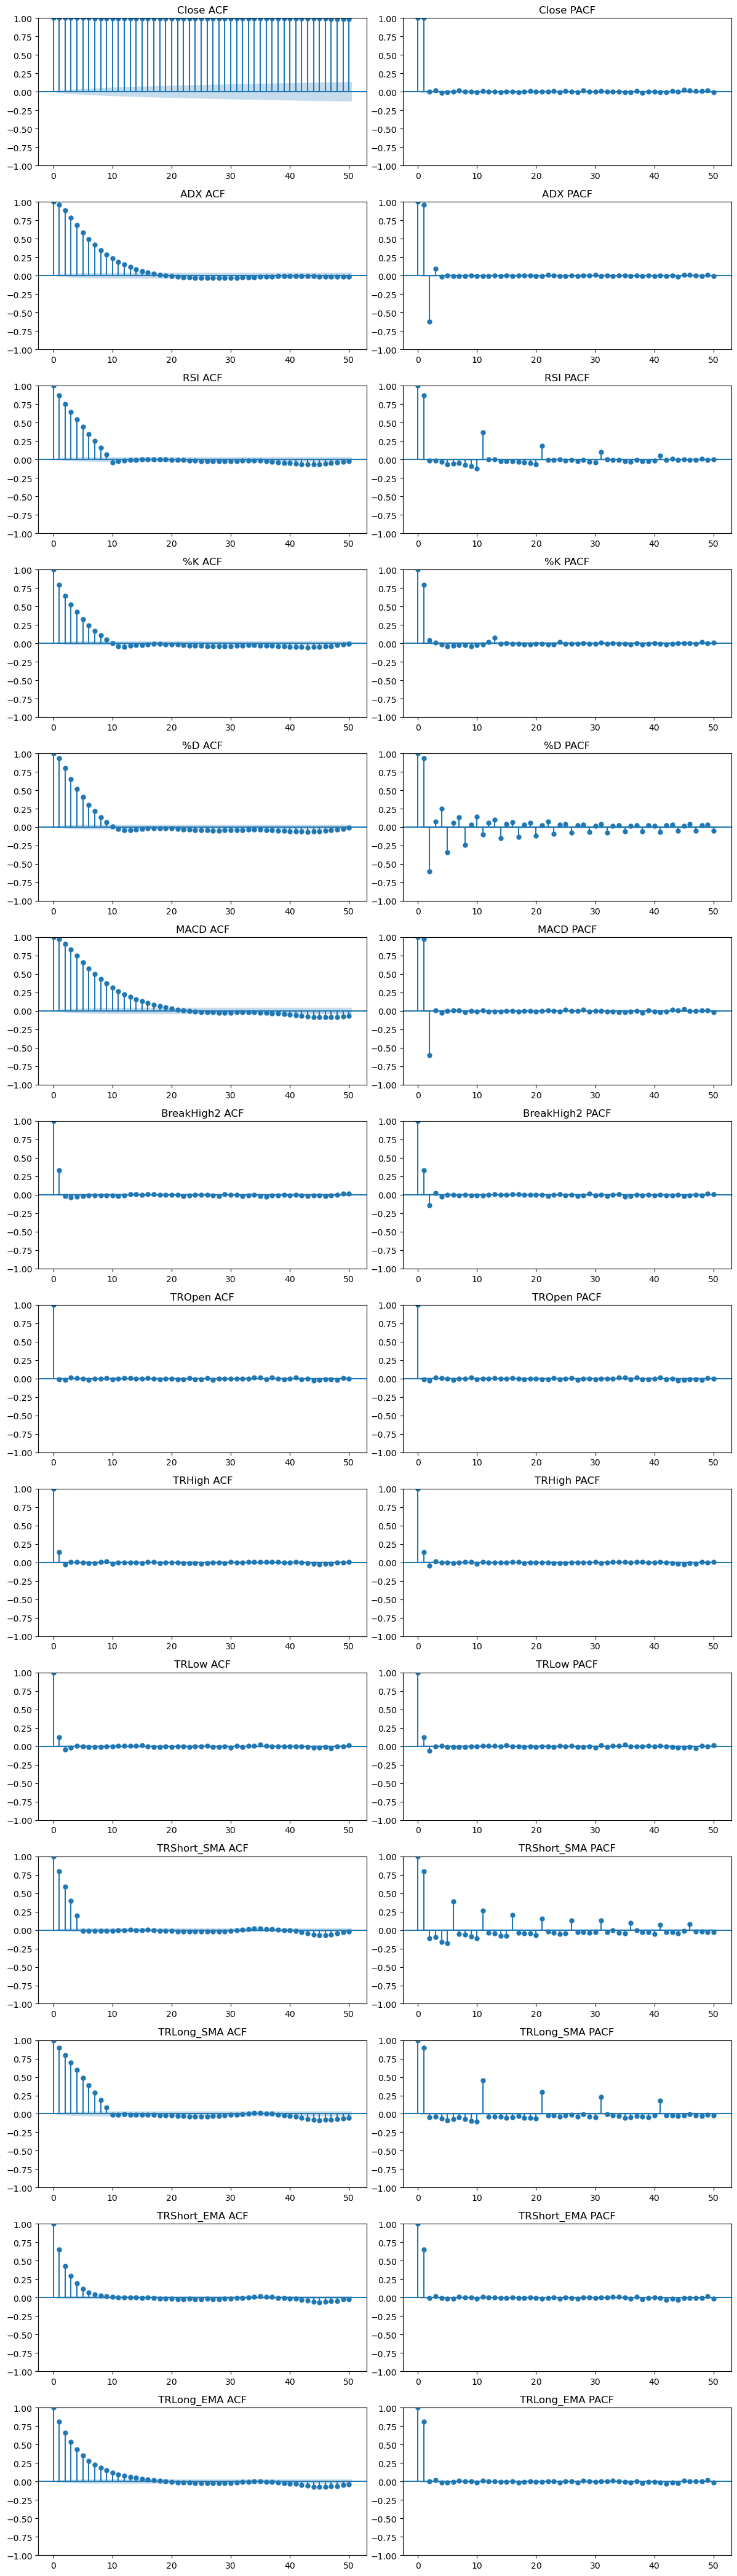

In [23]:
#plot the PACF for BTC
indicators = ['Close', 'ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA']

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(btc[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(btc[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()

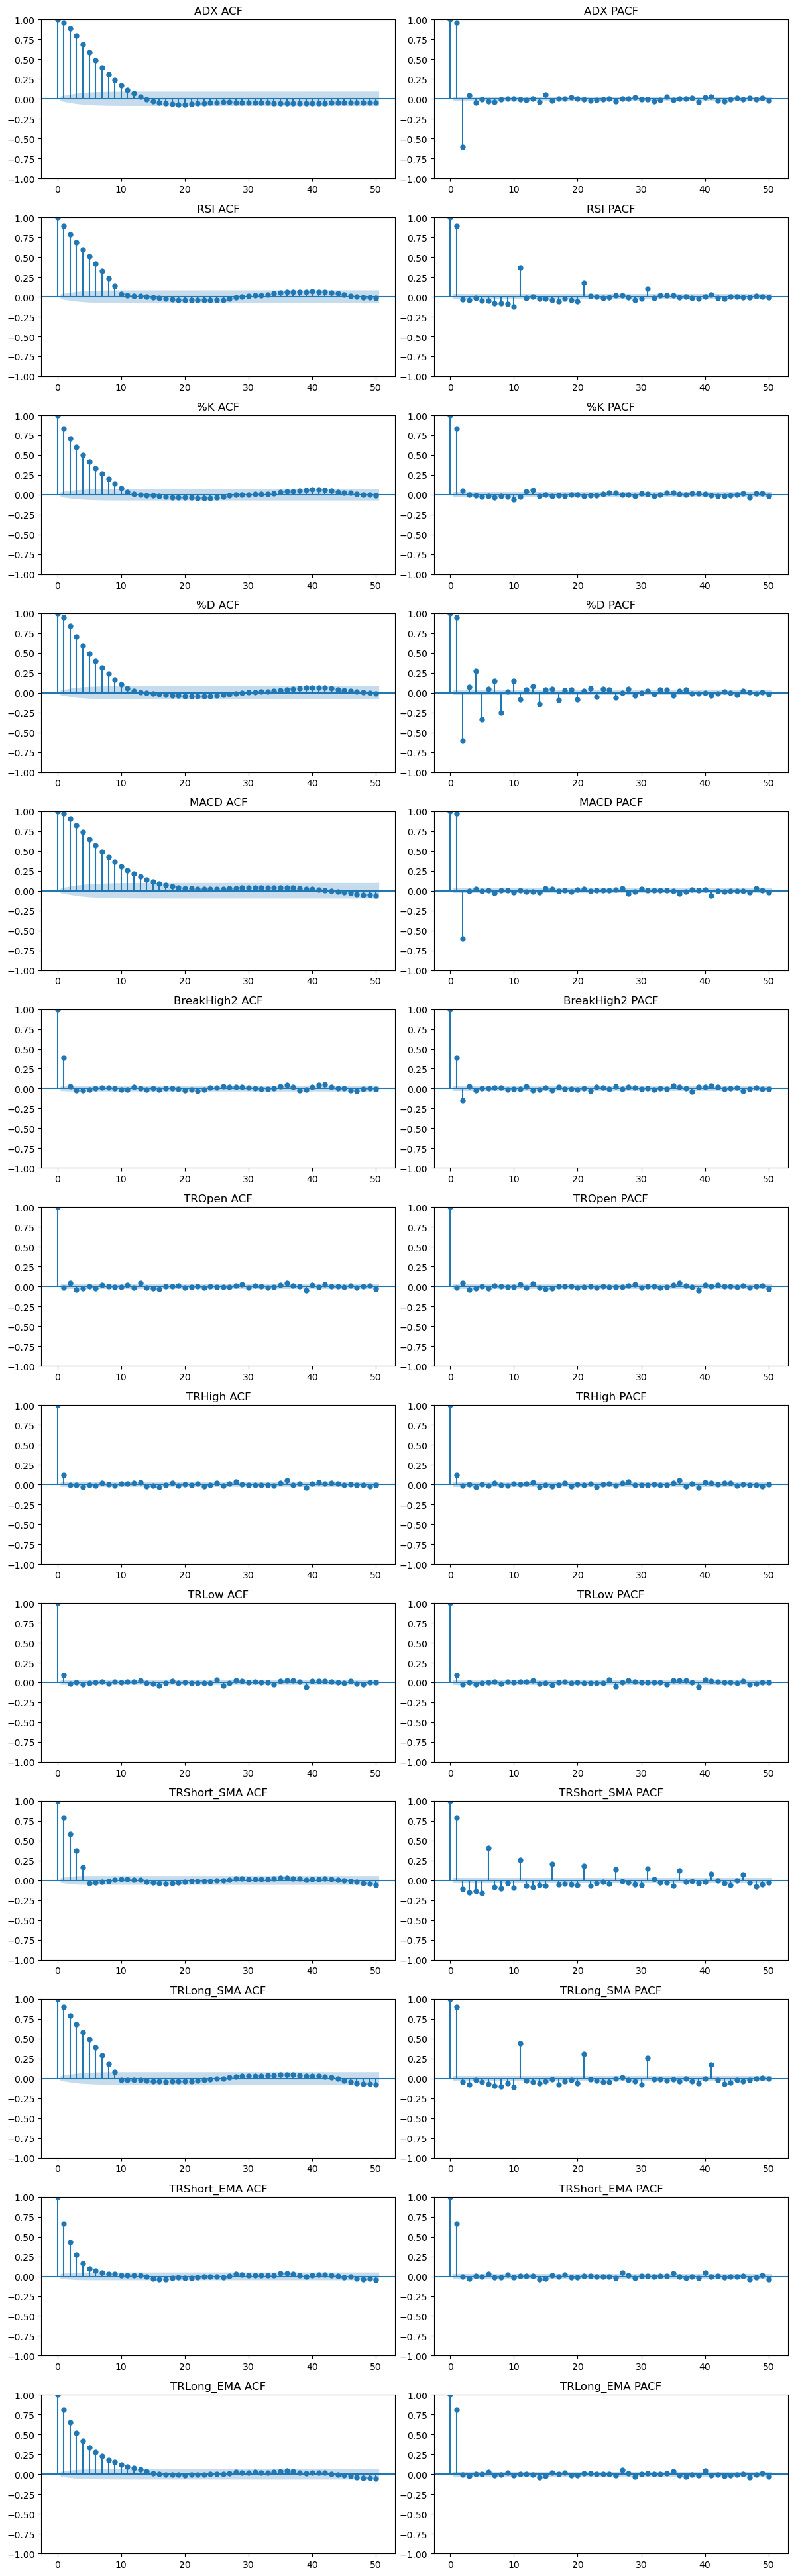

In [24]:
#plot the PACF for SPY
indicators = ['ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA']

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(spy[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(spy[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()

In [46]:
# construct the lags for btc
# Dictionary of variables and their respective lag counts
lags = {
    'ADX': 3, 'RSI': 2, '%K': 2, '%D': 3, 'MACD': 3, 'BreakHigh2': 2,
    'TROpen': 1, 'TRHigh': 1, 'TRLow': 1, 'TRShort_SMA': 2, 'TRLong_SMA': 2,
    'TRShort_EMA': 2, 'TRLong_EMA': 2, 'Close': 2
}

# Generate lagged features
for var, lag in lags.items():
    for i in range(1, lag + 1):
        btc[f'{var}_lag{i}'] = btc[var].shift(i)

#drop NA values
btc.dropna(inplace= True)
#calculate the number of observations (total)
num_observations_btc = len(btc)

In [47]:
# construct the lags for spy
# Dictionary of variables and their respective lag counts
lags = {
    'ADX': 3, 'RSI': 2, '%K': 2, '%D': 3, 'MACD': 3, 'BreakHigh2': 2,
    'TROpen': 1, 'TRHigh': 1, 'TRLow': 1, 'TRShort_SMA': 2, 'TRLong_SMA': 2,
    'TRShort_EMA': 2, 'TRLong_EMA': 2, 'Close': 2
}

# Generate lagged features
for var, lag in lags.items():
    for i in range(1, lag + 1):
        spy[f'{var}_lag{i}'] = spy[var].shift(i)

#drop NA values
spy.dropna(inplace=True)
#calculate the number of observations (total)
num_observations_spy = len(spy)

In [48]:
#check the number of observations from btc
num_observations_btc


21943

In [49]:
#check the number of observations from spy
num_observations_spy

4040

## BTC prediction with rolling window

In [76]:
btc = btc.reset_index()

# ignore march data for now
# btc = btc[btc['Date'] < '2025-03-01']
# print(len(btc[(btc['Date'] >= '2025-01-01') & (btc['Date'] < '2025-03-01')]))

print(len(btc[btc['Date'] >= '2025-03-01']))

# test_size = 2832 # for validation
test_size = 1364 # for test, march 2025

# Features and Target Varaible
target = 'Close'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

test_date = btc.iloc[-test_size:]['Date']

# Split data into training and testing sets
X = btc[features]
y = btc[target]

# Use the specified window for training
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

window_size = 4800 # last 100 days of data

1364


In [77]:
# Initialize lists to collect predictions
predictions2 = []

# Loop over the rolling window
for i in range(test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions2.append(y_pred[0])

In [78]:
result_df_btc = pd.DataFrame(test_date)
result_df_btc['Actual'] = y_test  # Add actual values
result_df_btc['Predicted'] = predictions2  # Add predicted values
result_df_btc['PrevClose'] = X_test[['Close_lag1']]
result_df_btc['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]

In [80]:
result_df_btc.to_csv('../data/btc_rf_predictions_rolling_march.csv')

## BTC end march - 1 april prediction

In [61]:
temp = pd.read_csv('../data/btc_rf_predictions_rolling_march.csv')
temp.tail(21)

,Unnamed: 0,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
1343,21714,2025-03-29 00:00:00,83885.06,83980.00808,84008.22,False
1344,21715,2025-03-29 00:30:00,83741.17,83823.01454,83885.06,False
1345,21716,2025-03-29 01:00:00,83701.08,83561.82836,83741.17,False
1346,21717,2025-03-29 01:30:00,83940.86,83546.28332,83701.08,False
1347,21718,2025-03-29 02:00:00,83772.83,83841.97954,83940.86,False
1348,21719,2025-03-29 02:30:00,83819.03,83827.22282,83772.83,True
1349,21720,2025-03-29 03:00:00,83731.02,83860.12644,83819.03,False
1350,21721,2025-03-29 03:30:00,83730.55,83737.08120,83731.02,False
1351,21722,2025-03-29 04:00:00,83836.42,83763.55902,83730.55,False
1352,21723,2025-03-29 04:30:00,83765.36,83871.33198,83836.42,False


In [52]:
btc = btc.reset_index()

# ignore march data for now
# btc = btc[btc['Date'] < '2025-03-01']
# print(len(btc[(btc['Date'] >= '2025-01-01') & (btc['Date'] < '2025-03-01')]))

print(len(btc[btc['Date'] >= '2025-03-29']))

229


In [ ]:
btc = btc.reset_index()

# ignore march data for now
# btc = btc[btc['Date'] < '2025-03-01']
# print(len(btc[(btc['Date'] >= '2025-01-01') & (btc['Date'] < '2025-03-01')]))

print(len(btc[btc['Date'] >= '2025-03-01']))

# test_size = 2832 # for validation
test_size = 208 # for test, march 2025

# Features and Target Varaible
target = 'Close'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

test_date = btc.iloc[-test_size:]['Date']

# Split data into training and testing sets
X = btc[features]
y = btc[target]

# Use the specified window for training
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

window_size = 4800 # last 100 days of data

In [57]:
# Initialize lists to collect predictions
predictions2 = []

# Loop over the rolling window
for i in range(test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions2.append(y_pred[0])

In [63]:
result_df_btc = pd.DataFrame(test_date)
result_df_btc['Actual'] = y_test  # Add actual values
result_df_btc['Predicted'] = predictions2  # Add predicted values
result_df_btc['PrevClose'] = X_test[['Close_lag1']]
result_df_btc['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]

In [65]:
result_df_btc.to_csv('../data/btc_rf_predictions_rolling_endmarch.csv')

## SPY prediction with rolling window

In [59]:
spy = spy.reset_index()
# ignore march data for now
# spy = spy[spy['Date'] < '2025-03-01']

In [60]:
# len(spy[(spy['Date'] >= '2025-01-01') & (spy['Date'] < '2025-03-01')])
len(spy[spy['Date'] >= '2025-03-01'])

270

In [61]:
# Features and Target Varaible
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features

X = spy[features]
y = spy[target]

window_size = 1300 # last 100 days of data (approximately)
test_size = 270 # Mar 2025

test_date = spy.iloc[-test_size:]['Date']
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

In [62]:
# Initialize lists to collect predictions
predictions_spy = []

# Loop over the rolling window
for i in range(test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions_spy.append(y_pred[0])

In [63]:
results_df_spy = pd.DataFrame(test_date)
results_df_spy['Actual'] = y_test  # Add actual values
results_df_spy['Predicted'] = predictions_spy  # Add predicted values
results_df_spy['PrevClose'] = X_test[['Close_lag1']]
results_df_spy['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]
results_df_spy

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
3744,2025-03-01 00:00:00,585.93,589.266180,588.88,True
3745,2025-03-01 00:30:00,587.35,587.233310,585.93,True
3746,2025-03-01 01:00:00,587.12,587.703154,587.35,False
3747,2025-03-01 01:30:00,583.45,587.412344,587.12,False
3748,2025-03-01 02:00:00,584.69,584.709228,583.45,False
...,...,...,...,...,...
4009,2025-03-29 01:30:00,556.38,557.153818,555.40,False
4010,2025-03-29 02:00:00,555.96,557.837720,556.38,False
4011,2025-03-29 02:30:00,556.14,557.381846,555.96,False
4012,2025-03-29 03:00:00,555.80,557.519892,556.14,False


In [64]:
results_df_spy.to_csv('../data/spy_rf_predictions_rolling_march.csv')

## SPY end march - 1 april prediction

In [66]:
temp = pd.read_csv('../data/spy_rf_predictions_rolling_march.csv')
temp.tail(8)

,Unnamed: 0,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
262,4006,2025-03-29 00:00:00,556.85,558.430930,557.94,False
263,4007,2025-03-29 00:30:00,556.52,557.618388,556.85,False
264,4008,2025-03-29 01:00:00,555.40,557.567978,556.52,False
265,4009,2025-03-29 01:30:00,556.38,557.153818,555.40,False
266,4010,2025-03-29 02:00:00,555.96,557.837720,556.38,False
267,4011,2025-03-29 02:30:00,556.14,557.381846,555.96,False
268,4012,2025-03-29 03:00:00,555.80,557.519892,556.14,False
269,4013,2025-03-29 03:30:00,555.73,556.893404,555.80,False


In [67]:
spy = spy.reset_index()
print(len(spy[spy['Date'] >= '2025-03-29']))

34


In [68]:
# Features and Target Varaible
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features

X = spy[features]
y = spy[target]

window_size = 1300 # last 100 days of data (approximately)
test_size = 26 # Mar 2025 last few days

test_date = spy.iloc[-test_size:]['Date']
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

In [69]:
# Initialize lists to collect predictions
predictions_spy = []

# Loop over the rolling window
for i in range(test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions_spy.append(y_pred[0])

In [70]:
results_df_spy = pd.DataFrame(test_date)
results_df_spy['Actual'] = y_test  # Add actual values
results_df_spy['Predicted'] = predictions_spy  # Add predicted values
results_df_spy['PrevClose'] = X_test[['Close_lag1']]
results_df_spy['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]
results_df_spy

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
4014,2025-03-31 21:30:00,549.725,556.076318,555.730,False
4015,2025-03-31 22:00:00,549.510,554.991012,549.725,False
4016,2025-03-31 22:30:00,551.710,556.230268,549.510,False
4017,2025-03-31 23:00:00,552.470,555.946520,551.710,True
4018,2025-03-31 23:30:00,553.340,555.423738,552.470,True
4019,2025-04-01 00:00:00,554.421,555.950770,553.340,True
4020,2025-04-01 00:30:00,553.260,555.911338,554.421,True
4021,2025-04-01 01:00:00,553.659,555.722202,553.260,False
4022,2025-04-01 01:30:00,553.100,556.537478,553.659,False
4023,2025-04-01 02:00:00,556.870,556.319258,553.100,False


In [71]:
results_df_spy.to_csv('../data/spy_rf_predictions_rolling_endmarch.csv')

### trading result using btc rolling window with window size of past 100 trading days

In [ ]:
btc_preds = pd.read_csv('../data/btc_rf_predictions_rolling.csv')
btc_w_preds = pd.read_csv('../data/btc_with_rf_predictions.csv')

In [ ]:
#merge the two dfs tgt based on Date
results_df2 = pd.merge(btc_preds, btc_w_preds, on = "Date")

In [ ]:
# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.001
trading_results2 = results_df2.copy().reset_index(drop=True)
initial_btc_price = trading_results2['Actual'].iloc[0]
btc_units = initial_investment / initial_btc_price
cash = 10000 # All money is initially in BTC

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results2['Predicted_Diff'] = trading_results2['Predicted']/trading_results2['PrevClose'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results2['Signal'] = 0
trading_results2.loc[(trading_results2['Predicted_Diff'] > 0.0024) & (trading_results2['BreakHigh2_lag1']), 'Signal'] = 1
trading_results2.loc[trading_results2['Predicted_Diff'] < -0.0024, 'Signal'] = 0

# Initialize portfolio value columns
trading_results2['BTC_Units'] = 0
trading_results2['Cash'] = 0
trading_results2['Portfolio_Value'] = 0

# Track position changes
trading_results2['Position_Change'] = trading_results2['Signal'].diff().abs()

# Simulate trading
for i in range(len(trading_results)):
    current_price = trading_results2['Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]
        
    # First row initialization
    if i == 0:
        trading_results2.at[i, 'BTC_Units'] = btc_units
        trading_results2.at[i, 'Cash'] = cash
        trading_results2.at[i, 'Portfolio_Value'] = btc_units * current_price
        continue
        
    prev_signal = trading_results2['Signal'].iloc[i-1]
    prev_btc = trading_results2['BTC_Units'].iloc[i-1]
    prev_cash = trading_results2['Cash'].iloc[i-1]
        
    # If signal changed, execute a trade
    if current_signal != prev_signal:
        if current_signal == 1:  # Buy BTC
            # Calculate commission
            commission = prev_cash * commission_rate
            # Convert cash to BTC
            new_btc = (prev_cash - commission) / current_price
            btc_units = prev_btc + new_btc
            cash = 0
        else:  # Sell BTC
            # Calculate commission
            commission = (prev_btc * current_price) * commission_rate
            # Convert BTC to cash
            cash = (prev_btc * current_price) - commission
            btc_units = 0
    else:
        # No change in position
        btc_units = prev_btc
        cash = prev_cash
        
    # Update portfolio value
    portfolio_value = (btc_units * current_price) + cash
        
    # Store values
    trading_results2.at[i, 'BTC_Units'] = btc_units
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

KeyError: 'PrevClose'

In [ ]:
# Calculate buy & hold strategy for comparison
initial_btc = initial_investment / trading_results2['Actual'].iloc[0]
trading_results2['Buy_Hold_Value'] = initial_btc * trading_results2['Actual']
    
# Calculate returns and metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment) - 1
num_trades = trading_results2['Position_Change'].sum()

In [ ]:
trading_results2

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1,Predicted_Diff,Signal,BTC_Units,Cash,Portfolio_Value,Position_Change
0,2025-01-01 00:00:00,94819.27,95302.3913,95282.72,False,0.000206,0,1.054638,10000.000000,100000.000000,NaN
1,2025-01-01 00:30:00,94687.97,94756.1522,94819.27,False,-0.000666,0,1.054638,10000.000000,109861.526038,0.0
2,2025-01-01 01:00:00,94358.80,94807.2666,94687.97,False,0.001260,0,1.054638,10000.000000,109514.370866,0.0
3,2025-01-01 01:30:00,93961.69,94528.1636,94358.80,False,0.001795,0,1.054638,10000.000000,109095.563592,0.0
4,2025-01-01 02:00:00,93836.11,94066.3525,93961.69,False,0.001114,0,1.054638,10000.000000,108963.122159,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2827,2025-02-28 21:30:00,81465.09,81829.5097,80695.28,True,0.014056,1,1.240326,0.000000,101043.276207,1.0
2828,2025-02-28 22:00:00,81785.98,82209.9950,81465.09,True,0.009144,1,1.240326,0.000000,101441.284444,0.0
2829,2025-02-28 22:30:00,82054.27,82421.4260,81785.98,True,0.007770,1,1.240326,0.000000,101774.051530,0.0
2830,2025-02-28 23:00:00,84317.02,82178.7531,82054.27,True,0.001517,0,0.000000,104476.018781,104476.018781,1.0


### trading result using btc rolling window, spy rolling window, tlt and cash with window size of past 100 trading days

In [51]:
spy = pd.read_csv("../data/spy_rf_predictions_rolling.csv")
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name = "TLT - iShares 20+ Year Bond")
btc = pd.read_csv("../data/btc_rf_predictions_rolling.csv")

In [52]:
#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

# Print the new column names to verify
print(df_spy.columns)

Index(['Unnamed: 0', 'Date', 'SPY_Actual', 'SPY_Predicted', 'SPY_PrevClose',
       'SPY_BreakHigh2_lag1'],
      dtype='object')


In [53]:
#rename btc columns
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])

# Print the new column names to verify
print(df_btc.columns) 

Index(['Unnamed: 0', 'Date', 'BTC_Actual', 'BTC_Predicted', 'BTC_PrevClose',
       'BTC_BreakHigh2_lag1'],
      dtype='object')


In [54]:
### rename the TLT columns

columns = tlt.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'TLT_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_tlt = tlt.rename(columns=rename_dict)

df_tlt["Date"] = pd.to_datetime(df_tlt["Date"])

# Print the new column names to verify
print(df_tlt.columns) 

Index(['Date', 'TLT_Open', 'TLT_High', 'TLT_Low', 'TLT_Close',
       'TLT_SMAVG (5)  on Close', 'TLT_SMAVG (10)  on Close',
       'TLT_SMAVG (15)  on Close', 'TLT_Volume', 'TLT_SMAVG (5)'],
      dtype='object')


In [63]:
#merge all the dfs tgt
df = pd.merge(df_btc, df_spy, on = "Date", how = "left")
df_combined = pd.merge(df, df_tlt, on = "Date", how = "left")

In [64]:
df_combined.head()

,Unnamed: 0_x,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,BTC_BreakHigh2_lag1,Unnamed: 0_y,SPY_Actual,SPY_Predicted,SPY_PrevClose,SPY_BreakHigh2_lag1,TLT_Open,TLT_High,TLT_Low,TLT_Close,TLT_SMAVG (5) on Close,TLT_SMAVG (10) on Close,TLT_SMAVG (15) on Close,TLT_Volume,TLT_SMAVG (5)
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False,3237.0,586.900,588.502670,588.730,False,88.065,88.065,87.56,87.570,87.961,87.902,87.863,1463486.0,2993670.0
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False,3238.0,587.060,586.968758,586.900,False,87.570,87.650,87.48,87.575,87.916,87.876,87.847,2488418.0,1716545.0
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False,3239.0,585.860,587.495580,587.060,False,87.575,87.585,87.34,87.525,87.771,87.842,87.829,1582935.0,1724840.0
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False,3240.0,587.205,585.988060,585.860,False,87.530,87.765,87.43,87.610,87.669,87.818,87.821,3499756.0,2161849.0
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False,3241.0,584.960,586.748484,587.205,False,87.610,87.635,87.39,87.422,87.540,87.773,87.799,1925135.0,2191946.0


In [66]:
import numpy as np

# ==========================
# Initial Parameters Setup
# ==========================
initial_investment = 100000  # Starting portfolio value in USD
cash_buffer = 0.05  # Maintain 5% cash reserve at all times
tlt_allocation = 0.20  # 20% allocation to TLT bonds (risk-free asset)
risk_allocation = 0.70  # 70% allocation to risk assets (BTC or SPY)
commission_rate = 0.001  # 0.1% commission per trade
holding_period = 240  # SPY must be held for at least 5 days (~48 periods/day)

# Copy dataframe to prevent modification of original data
trading_results = df_combined.copy().reset_index(drop=True)

# ==============================
# Initialize Market Prices
# ==============================
initial_btc_price = trading_results['BTC_Actual'].iloc[0]
initial_spy_price = trading_results['SPY_Actual'].iloc[0]
initial_tlt_price = trading_results['TLT_Close'].iloc[0]

# ==============================
# Initial Portfolio Allocation
# ==============================
initial_cash = initial_investment * cash_buffer  # Set aside cash buffer
initial_tlt_value = initial_investment * tlt_allocation  # TLT allocation
initial_risk_value = initial_investment * risk_allocation  # BTC/SPY allocation

# Flag when SPY and TLT markets are closed
trading_results['SPY_Closed'] = trading_results['SPY_Actual'].isna()
trading_results['TLT_Closed'] = trading_results['TLT_Close'].isna()

# ============================================================
# Compute Rolling Volatility (Risk Estimation)
#    - Used for risk-adjusted return and dynamic allocation
#    - Rolling window of 1440 periods (approximates 30 days)
# ============================================================
trading_results['BTC_Volatility'] = trading_results['BTC_Actual'].pct_change().rolling(1440).std()
trading_results['SPY_Volatility'] = trading_results['SPY_Actual'].pct_change().rolling(1440).std()

# ============================================================
# Dynamic Risk Allocation:
#    - Allocate more capital to the *less volatile* asset
#    - Prevents overexposure to high-volatility assets (BTC)
# ============================================================
trading_results['BTC_Weight'] = (1 / trading_results['BTC_Volatility']) / (
    (1 / trading_results['BTC_Volatility']) + (1 / trading_results['SPY_Volatility'])
)
trading_results['SPY_Weight'] = 1 - trading_results['BTC_Weight']

# ============================================================
# Compute Predicted Returns from ML Model
# ============================================================
trading_results['BTC_Return'] = trading_results['BTC_Predicted'] / trading_results['BTC_PrevClose'] - 1
trading_results['SPY_Return'] = trading_results['SPY_Predicted'] / trading_results['SPY_PrevClose'] - 1

# ============================================================
# Adjust Risk-Adjusted Returns Using Annualized Volatility
#    - This ensures fair comparison between BTC & SPY
# ============================================================
annualization_factor = np.sqrt(48 * 365)  # Convert 30-min volatility to annualized scale
trading_results['BTC_RiskAdj_Return'] = trading_results['BTC_Return'] / (trading_results['BTC_Volatility'] * annualization_factor)
trading_results['SPY_RiskAdj_Return'] = trading_results['SPY_Return'] / (trading_results['SPY_Volatility'] * annualization_factor)

# ============================================================
# Trading Signal Generation (Based on Risk-Adjusted Returns)
#    - If BTC's risk-adjusted return > SPY's, allocate to BTC
#    - Otherwise, allocate to SPY
# ============================================================
trading_results['Signal'] = np.where(
    trading_results['BTC_RiskAdj_Return'] > trading_results['SPY_RiskAdj_Return'], 1, 2
)

# ============================================================
# Apply Minimum Holding Period for SPY
#    - Prevents excessive switching between BTC and SPY
#    - Ensures SPY is held for at least 5 trading days (240 periods)
# ============================================================
trading_results['Holding'] = trading_results['Signal'].shift(1)  # Store previous position
trading_results['Signal'] = np.where(
    (trading_results['Holding'] == 2) & (trading_results['BTC_RiskAdj_Return'] < trading_results['SPY_RiskAdj_Return'] * 1.2),
    2,  # Keep holding SPY unless BTC's return is significantly better
    trading_results['Signal']
)

# ============================
# Portfolio Initialization
# ============================
trading_results['BTC_Units'] = 0.0
trading_results['SPY_Units'] = 0.0
trading_results['TLT_Units'] = initial_tlt_value / initial_tlt_price
trading_results['Cash'] = initial_cash
trading_results['Portfolio_Value'] = 0.0

# ============================================================
# First Day Portfolio Allocation (Using Dynamic Risk Weights)
# ============================================================
trading_results.at[0, 'BTC_Units'] = (initial_risk_value * trading_results['BTC_Weight'].iloc[0]) / initial_btc_price
trading_results.at[0, 'SPY_Units'] = (initial_risk_value * trading_results['SPY_Weight'].iloc[0]) / initial_spy_price
trading_results.at[0, 'Portfolio_Value'] = initial_investment

# Track position changes
trading_results['Position_Change'] = trading_results['Signal'].diff().abs()

C:\Users\jessi\AppData\Local\Temp\ipykernel_16704\3512031336.py:40: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  trading_results['SPY_Volatility'] = trading_results['SPY_Actual'].pct_change().rolling(1440).std()


In [67]:
# ============================================================
# Trading Simulation Loop (Iterate Through Time Periods)
# ============================================================
for i in range(1, len(trading_results)):
    current_btc_price = trading_results['BTC_Actual'].iloc[i]
    current_spy_price = trading_results['SPY_Actual'].iloc[i] if not trading_results['SPY_Closed'].iloc[i] else trading_results['SPY_Actual'].iloc[i-1]
    current_tlt_price = trading_results['TLT_Close'].iloc[i] if not trading_results['TLT_Closed'].iloc[i] else trading_results['TLT_Close'].iloc[i-1]
    
    prev_btc = trading_results['BTC_Units'].iloc[i-1]
    prev_spy = trading_results['SPY_Units'].iloc[i-1]
    prev_tlt = trading_results['TLT_Units'].iloc[i-1]
    prev_cash = trading_results['Cash'].iloc[i-1]
    prev_signal = trading_results['Signal'].iloc[i-1]
    current_signal = trading_results['Signal'].iloc[i]

    spy_closed = trading_results['SPY_Closed'].iloc[i]
    tlt_closed = trading_results['TLT_Closed'].iloc[i]

    # Maintain minimum cash buffer
    btc_value = prev_btc * current_btc_price
    spy_value = prev_spy * current_spy_price
    tlt_value = prev_tlt * current_tlt_price
    total_value = btc_value + spy_value + tlt_value + prev_cash
    required_cash = total_value * cash_buffer
    available_cash = max(prev_cash, required_cash)

    # Prevent trading SPY when market is closed
    if prev_signal != current_signal:
        if current_signal == 2 and spy_closed:
            # If switching to SPY but market is closed, defer trade
            trading_results.at[i, 'Signal'] = prev_signal  
        else:
            # Sell previous risk asset
            if prev_signal == 1:
                sale_proceeds = btc_value * (1 - commission_rate)
                trading_results.at[i, 'BTC_Units'] = 0
            elif prev_signal == 2 and not spy_closed:
                sale_proceeds = spy_value * (1 - commission_rate)
                trading_results.at[i, 'SPY_Units'] = 0
            
            # Allocate new risk capital
            risk_capital = (total_value - available_cash) * risk_allocation
            tlt_capital = (total_value - available_cash) * tlt_allocation
            
            # Buy new risk asset only if markets are open
            btc_units = (risk_capital * trading_results['BTC_Weight'].iloc[i] * (1 - commission_rate)) / current_btc_price
            spy_units = (risk_capital * trading_results['SPY_Weight'].iloc[i] * (1 - commission_rate)) / current_spy_price if not spy_closed else 0
            
            trading_results.at[i, 'BTC_Units'] = btc_units
            trading_results.at[i, 'SPY_Units'] = spy_units
                
            # Rebalance TLT only if market is open
            tlt_units = (tlt_capital * (1 - commission_rate)) / current_tlt_price if not tlt_closed else prev_tlt
            trading_results.at[i, 'TLT_Units'] = tlt_units
            
            # Update cash balance
            trading_results.at[i, 'Cash'] = available_cash - (risk_capital + tlt_capital) * commission_rate
    
    # Compute final portfolio value
    final_value = btc_value + spy_value + tlt_value + trading_results.at[i, 'Cash']
    trading_results.at[i, 'Portfolio_Value'] = final_value

In [68]:
#buy and hold strategy for spy
#Calculate buy & hold strategy for comparison
initial_spy = initial_investment / trading_results['SPY_Actual'].iloc[0]
trading_results['SPY_Buy_Hold_Value'] = initial_spy * trading_results['SPY_Actual']

initial_tlt = initial_investment / trading_results["TLT_Close"].iloc[0]
trading_results["TLT_Buy_Hold_Value"] = initial_tlt * trading_results["TLT_Close"]
    
# Calculate returns and metrics
total_return = (trading_results['Portfolio_Value'].iloc[-1] / initial_investment) - 1
num_trades = trading_results['Position_Change'].sum()

In [69]:
#check trading results
trading_results.head()

,Unnamed: 0_x,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,BTC_BreakHigh2_lag1,Unnamed: 0_y,SPY_Actual,SPY_Predicted,SPY_PrevClose,...,Signal,Holding,BTC_Units,SPY_Units,TLT_Units,Cash,Portfolio_Value,Position_Change,SPY_Buy_Hold_Value,TLT_Buy_Hold_Value
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False,3237.0,586.900,588.502670,588.730,...,2,NaN,NaN,NaN,228.388718,5000.0,100000.000000,NaN,100000.000000,100000.000000
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False,3238.0,587.060,586.968758,586.900,...,2,2.0,0.0,0.0,228.388718,5000.0,NaN,0.0,100027.261884,100005.709718
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False,3239.0,585.860,587.495580,587.060,...,2,2.0,0.0,0.0,228.388718,5000.0,24989.722508,0.0,99822.797751,99948.612539
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False,3240.0,587.205,585.988060,585.860,...,2,2.0,0.0,0.0,228.388718,5000.0,25009.135549,0.0,100051.967967,100045.677744
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False,3241.0,584.960,586.748484,587.205,...,2,2.0,0.0,0.0,228.388718,5000.0,24966.198470,0.0,99669.449651,99830.992349


## Old attempt

In [ ]:
window_size = 3498  # Training window (1st jan 2024 - 31st dec 2024)
test_size = 3745-3498      # Testing window (1st jan - 28 feb 2025)

# Features and Target Variable
target = 'Close'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

In [ ]:
# Define Rolling Window Parameters
window_size = 3498  # Training window: 1st Jan 2024 - 31st Dec 2024
test_size = 3745 - 3498  # Testing window: 1st Jan - 28th Feb 2025
param_grid = [100, 200, 500]  # Hyperparameter tuning (number of trees)

# Features and Target Variable
target = "Close"
features = [col for col in btc.columns if "lag" in col]  # Select only lagged features
max_features_value = max(1, int(len(features) / 3))  # Ensure at least 1 feature

# Initialize storage for predictions and results
test_dates = btc.iloc[-test_size:]["DATE"].values
predictions_df = pd.DataFrame({"date": test_dates, "pred": np.nan})

# Rolling Window Loop
for start in range(len(btc) - window_size - test_size + 1):
    # Define rolling train and test sets
    train_data = btc.iloc[start : start + window_size]
    test_data = btc.iloc[start + window_size : start + window_size + 1]  # Predict next step

    if test_data.empty:
        break  # Stop if no more test data left

    # Extract X and y
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Nested Cross-Validation (Tuning n_estimators)
    best_n_estimators = None
    lowest_rmse = float("inf")

    for n_estimators in param_grid:
        inner_rmse = []

        for inner_start in range(0, len(X_train) - test_size, test_size):
            X_inner_train = X_train[inner_start : inner_start + (window_size - test_size)]
            X_inner_val = X_train[inner_start + (window_size - test_size) : inner_start + window_size]
            y_inner_train = y_train.iloc[inner_start : inner_start + (window_size - test_size)]
            y_inner_val = y_train.iloc[inner_start + (window_size - test_size) : inner_start + window_size]

            if len(X_inner_train) == 0 or len(X_inner_val) == 0:
                continue  # Skip invalid splits

            model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_features=max_features_value)
            model.fit(X_inner_train, y_inner_train)
            y_inner_pred = model.predict(X_inner_val)
            rmse = np.sqrt(mean_squared_error(y_inner_val, y_inner_pred))
            inner_rmse.append(rmse)

        if inner_rmse:
            mean_rmse = np.mean(inner_rmse)

            # Select best n_estimators
            if mean_rmse < lowest_rmse:
                lowest_rmse = mean_rmse
                best_n_estimators = n_estimators

    # Ensure a valid hyperparameter was selected
    if best_n_estimators is None:
        raise ValueError("Hyperparameter tuning failed. No valid n_estimators selected.")

    # Train final model with best hyperparameters
    best_model_btc = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42, max_features=max_features_value)
    best_model_btc.fit(X_train, y_train)

    # Predict and store result
    predictions_df.iloc[start, 1] = best_model.predict(X_test)[0]

# Merge Predictions with BTC Data
btc.loc[btc["DATE"].isin(predictions_df["date"]), "Predicted_Close"] = predictions_df["pred"]

# Calculate RMSE
actuals = btc.loc[btc["DATE"].isin(predictions_df["date"]), target]
mse = mean_squared_error(actuals, predictions_df["pred"])
rmse = np.sqrt(mse)

# Print final results
print(f"Optimal n_estimators for BTC: {best_n_estimators}")
print(f"RMSE BTC (Rolling Window): {rmse:.4f}")

In [ ]:
btc.to_csv("btc_preds.csv")

In [ ]:
#plot the feature importance
# Get the feature importances from the best model
importances = best_model_btc.feature_importances_

# Create a DataFrame with feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting BTC Closing Price')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

### Train random forest for SPY

In [ ]:
window_size = 3238  # Training window (Jan - Dec 2024)
test_size = 3745-3238 # Testing window (Jan-Feb 2025)

# Features and Target Variable
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features

In [ ]:
# Features and Target Variable
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features
max_features_value = int(len(features) / 3)  # Define max_features value

# Perform Nested Rolling Window Cross-Validation
predictions = []
actuals = []
test_indices = []

for start in range(0, len(spy) - window_size - test_size, test_size):
    # Outer Loop: Train/Test Split with Rolling Window
    train = spy.iloc[start : start + window_size]
    test = spy.iloc[start + window_size : start + window_size + test_size]

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Inner Loop: Hyperparameter tuning using a rolling window approach
    best_n_estimators = None
    lowest_rmse = float('inf')

    for n_estimators in param_grid:
        inner_rmse = []

        for inner_start in range(0, len(X_train) - window_size, test_size):
            X_inner_train = X_train[inner_start : inner_start + window_size]
            X_inner_val = X_train[inner_start + window_size : inner_start + window_size + test_size]
            y_inner_train = y_train.iloc[inner_start : inner_start + window_size]
            y_inner_val = y_train.iloc[inner_start + window_size : inner_start + window_size + test_size]

            # Train and validate model
            model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_features=max_features_value)
            model.fit(X_inner_train, y_inner_train)
            y_inner_pred = model.predict(X_inner_val)
            rmse = np.sqrt(mean_squared_error(y_inner_val, y_inner_pred))
            inner_rmse.append(rmse)

        # Compute average RMSE over inner folds
        mean_rmse = np.mean(inner_rmse)

        # Select best n_estimators based on RMSE
        if mean_rmse < lowest_rmse:
            lowest_rmse = mean_rmse
            best_n_estimators = n_estimators

    # Train final model with best hyperparameters
    best_model_spy = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42, max_features=max_features_value)
    best_model_spy.fit(X_train, y_train)

    # Predict on test set
    y_pred = best_model_spy.predict(X_test)
    predictions.extend(y_pred)
    actuals.extend(y_test)
    test_indices.extend(test.index)  # Save test indices for mapping

# Map predictions back to the original BTC dataframe
spy.loc[test_indices, 'Predicted_Close'] = predictions

# Calculate overall RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# Print best hyperparameter and RMSE
print(f'Optimal n_estimators for SPY: {best_n_estimators}')
print(f'RMSE SPY: {rmse:.4f}')

In [ ]:
spy.to_csv("spy_preds.csv")

In [ ]:
#plot the feature importance
# Get the feature importances from the best model
importances = best_model_spy.feature_importances_

# Create a DataFrame with feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting SPY Closing Price')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()